# M4HW Assignment: P Burke
## Module 4 Project

For this assignment, use the ERA-5 *monthly mean* data at NCAR (DOI: 10.5065/P8GT-0R61) as we did in Module 2.  Feel free to reduce the data to 1 degree resolution if you need to save data download times.

**Task 1.** Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and precipitation anomalies from Jan 1979-Dec 2021 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.distributed import Client, progress


In [2]:
client = Client()  # set up local cluster on for this assignment
client

c:\Users\pburke\AppData\Local\R-MINI~1\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55346 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:55346/status,
Dashboard: http://127.0.0.1:55346/status,Workers: 4
Total threads: 12,Total memory: 31.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55347,Workers: 4
Dashboard: http://127.0.0.1:55346/status,Total threads: 12
Started: Just now,Total memory: 31.78 GiB
Comm: tcp://127.0.0.1:55387,Total threads: 3
Dashboard: http://127.0.0.1:55388/status,Memory: 7.94 GiB
Nanny: tcp://127.0.0.1:55351,


In [27]:
server = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/'
suffix= '.nc'

# Extensions
base_url_sst = 'e5.moda.an.sfc/'
base_url_pr = 'e5.moda.fc.sfc.accumu/'
ext_sst='/e5.moda.an.sfc.128_034_sstk.ll025sc.'
ext_pr ='/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list_sst=[]
file_list_pr=[]

for dt in pr:
    # get recent year
    year = dt.strftime('%Y')

    # build complete file name
    #https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc
    single_file_sst=(server+base_url_sst+year+'/e5.moda.an.sfc.128_034_sstk.ll025sc.'+year+'010100_'+year+'120100'+suffix)
    #https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc
    single_file_pr=(server+base_url_pr+year+'/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'+year+'010100_'+year+'120100'+suffix)

    file_list_sst.append(single_file_sst)
    file_list_pr.append(single_file_pr)


Write a function to download data from user-specified station ID:

In [29]:
%%time

ds_pr = xr.open_mfdataset(file_list_pr, parallel=True).sel(latitude=slice(65, -65), longitude=slice(120, 300))['TP']
ds_sst = xr.open_mfdataset(file_list_sst, parallel=True).sel(latitude=slice(65, -65), longitude=slice(120, 300))['SSTK']


CPU times: total: 1.06 s
Wall time: 16.8 s


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 516)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK       (time, latitude, longitude) float32 dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

Get the land sea mask for ERA-5 (in 1979)

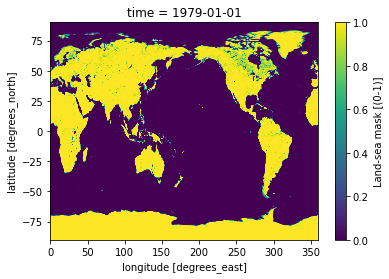

In [5]:
lsm = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
                      engine='netcdf4')



Slice the mask to the Pacific Basin (65°N to 65°S, 120°E to 60°W). Note for each slice, min value then max value is listed

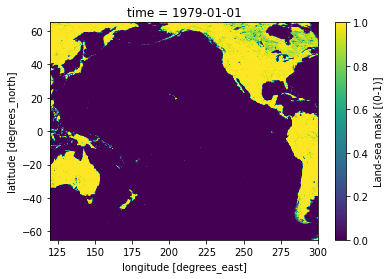

In [31]:
lsm_area = lsm['LSM'].sel(latitude=slice(65,-65,1),
                         longitude=slice(120,360-60,1))

lsm_area.plot()                         

Not sure why 'LSM' disappears from the xarray DataSet.

TO DO: mask the land out of dataset

In [15]:
#ds_PAC.coords['mask'] = (('latitude', 'longitude'), lsm_area)
#ds_PACmask = ds_PAC.sstk.where(lsm.mask.isel(time=0) == 1)
print(ds_sstk)

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    long_name:                     Sea surface temperature
    short_name:                    sstk
    units:                         K
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               34
    minimum_value:                 269.3069
    maximum_value:                 306.40942
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds63

#### **Action 2.** Deseasonalize, detrend, and standardize the SST anomalies. 
**Deseasonalize** means remove the mean monthly anomaly from the annual mean from each point. From Steve: "Deseasonalization as defined here is subtracting the long term monthly mean from each month in the time series at every point in the dataset.  Your input dimensions and output dimensions will not change - it will still be time, lat, lon"  
**Detrend** means equalize a linear trend in the data. First, look at the data in a plot. Then fit linear regression. From Steve: "Your linear regression model will return a slope and intercept parameter at each point.  Mathematically, it then just becomes a matter of subtracting the linear fit from the original time series.  In `xarray`, it becomes pretty easy"  
**Standardization** means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)
   
Hints: [Monthly data analysis &#8212; PyCLIM_101 0.2 documentation](https://climate.usu.edu/people/yoshi/pyclm101/monthly.html)

**Deseasonalize** 

In [32]:
#feom https://climate.usu.edu/people/yoshi/pyclm101/monthly.html
clm = ds_sstk.sel(time=slice('1979-1-1','2021-12-31')).groupby('time.month').mean(dim='time')
anm = (ds_sstk.groupby('time.month') - clm)

In [17]:
anm

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

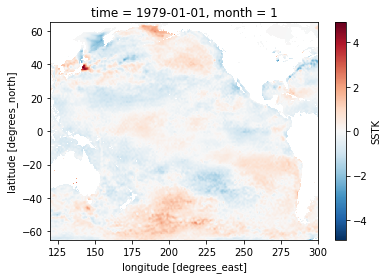

In [39]:
anm.isel(time=0).plot()

**Detrend** 

(array([1.80000000e+01, 1.15000000e+02, 2.55300000e+03, 2.61152000e+05,
        1.17327225e+08, 3.77747200e+07, 1.88357000e+05, 4.71200000e+03,
        6.06000000e+02, 9.40000000e+01]),
 array([-13.615631  , -10.815866  ,  -8.016101  ,  -5.2163363 ,
         -2.4165711 ,   0.38319397,   3.182959  ,   5.982724  ,
          8.782489  ,  11.582254  ,  14.382019  ], dtype=float32),
 <BarContainer object of 10 artists>)

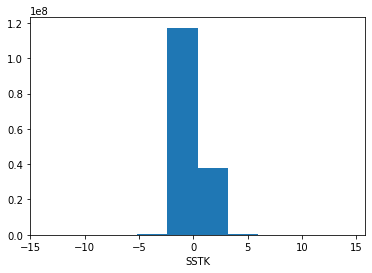

In [33]:
anm.plot()

Great, that historgam looks like anomolies (normal curve). Next is figuring out how to run a linear regression on `xarray` dataset. Use code snippet from Slack (also at PyCLIM_101)

In [34]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [35]:
anm_detrend = detrend_dim(anm,'time',1)

In [36]:
# drop month coords
anm_detrend = anm_detrend.drop('month')
anm_detrend

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
dask.array<sub, shape=(516, 521, 721), dtype=float64, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

2022-12-19 17:17:48,316 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:55378 (pid=24608) exceeded 95% memory budget. Restarting...
2022-12-19 17:17:48,877 - distributed.nanny - WARNING - Restarting worker


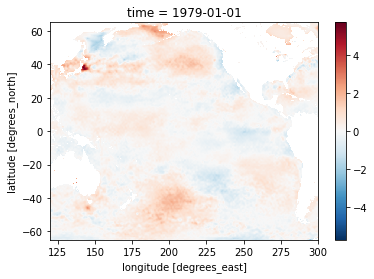

In [37]:
anm_detrend.isel(time=0).plot()

**Standardize** 

In [44]:
climatology_mean = anm_detrend.groupby('time.month').mean('time')
climatology_std = anm_detrend.groupby('time.month').std('time')

stand_anomalies = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                  anm_detrend.groupby('time.month'),
                                  climatology_mean, climatology_std,
                                  dask='parallelized')

In [45]:
len(anm_detrend.groupby('time.month'))

12

In [48]:
sstk_final = stand_anomalies.drop('month').compute()

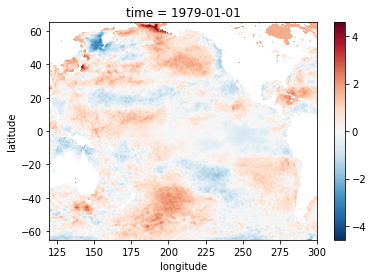

In [49]:
sstk_final.isel(time=0).plot()

In [50]:
sstk_final.to_netcdf('sstk_anom.nc')

**Action 3.** Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [52]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

In [54]:
# latitude weights are applied before the computation of EOFs.

coslat = np.cos(np.deg2rad(sstk_final.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Create an EOF solver to do the EOF analysis.
solver = Eof(sstk_final, weights=wgts)
eofs = solver.eofsAsCorrelation(neofs=5)

Couldn't get the weights into the `EOFs.xarray()` call. Carrying on anyway...

Text(0.5, 1.0, 'EOF1 expressed as correlation')

c:\Users\pburke\AppData\Local\R-MINI~1\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


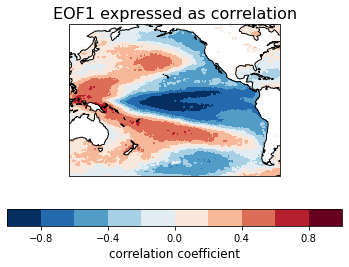

In [56]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eofs[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'EOF2 expressed as correlation')

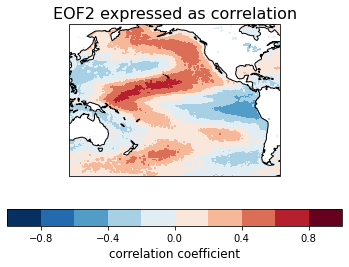

In [57]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eofs[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'EOF3 expressed as correlation')

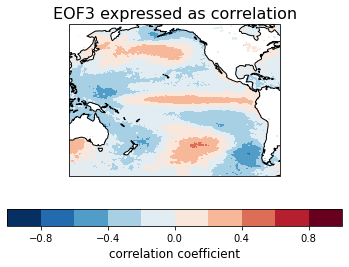

In [58]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eofs[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF3 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'EOF4 expressed as correlation')

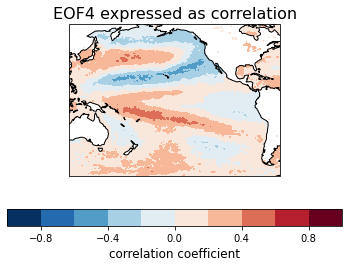

In [59]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eofs[3].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF4 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'EOF5 expressed as correlation')

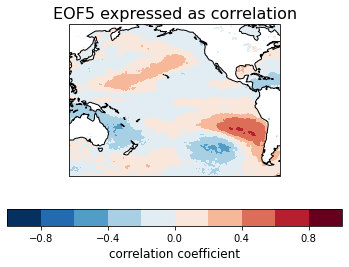

In [60]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eofs[4].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF5 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'PC1 Time Series')

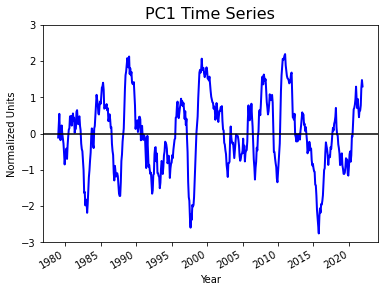

In [64]:
# Plot the leading PC time series.
pc1 = solver.pcs(npcs=2, pcscaling=1)

plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

**Action 4.** Plot the percent of variance explained by the first 10 EOFs.

In [62]:
varfrac = solver.varianceFraction()

(9.788313717954543e-32, 0.19006352385009875)

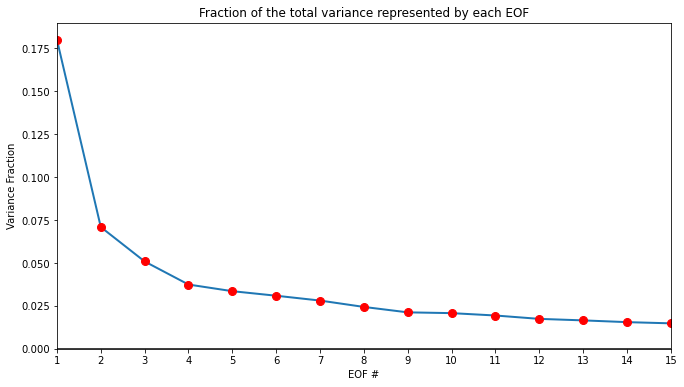

In [63]:
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

**Action 5.** Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

In [69]:
reconstruction = solver.reconstructedField(5)

In [70]:
sst_corr = xr.corr(reconstruction, anm, dim='time')

Text(0.5, 1.0, 'Correlation btw Reconstructed SST and Observed')

c:\Users\pburke\AppData\Local\R-MINI~1\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


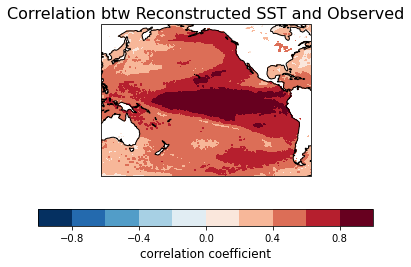

In [71]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = sst_corr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('Correlation btw Reconstructed SST and Observed', fontsize=16)

**Action 6.** Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot).  See anything interesting?

In [73]:
sst_corr2 = xr.corr(eofs[1], sstk_final, dim='time')

c:\Users\pburke\AppData\Local\R-MINI~1\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pburke\AppData\Local\R-MINI~1\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation btw SST EOF1 and Detrended')

c:\Users\pburke\AppData\Local\R-MINI~1\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


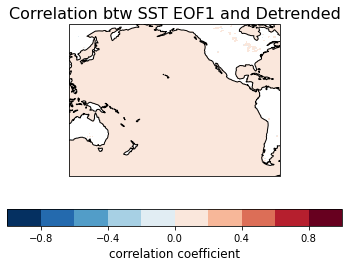

In [74]:
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = sst_corr2.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('Correlation btw SST EOF1 and Detrended', fontsize=16)

In [75]:

client.close()